In [1]:
import awkward as ak
import hist
import jax
import matplotlib.pyplot as plt
import numpy as np
import uproot
import vector
import urllib
from tqdm.notebook import tqdm

vector.register_awkward()
ak.jax.register_and_check()

In [2]:
ttbar_file = "https://github.com/scikit-hep/scikit-hep-testdata/"\
    "raw/main/src/skhep_testdata/data/nanoAOD_2015_CMS_Open_Data_ttbar.root"

with uproot.open(ttbar_file) as f:
    arr = f["Events"].arrays(["Jet_pt","Jet_eta", "Jet_phi", "Jet_mass"])

# ttbar_file = "https://xrootd-local.unl.edu:1094//store/user/AGC/nanoAOD/"\
#     "TT_TuneCUETP8M1_13TeV-powheg-pythia8/cmsopendata2015_ttbar_19981_PU25nsData2015v1_76X_"\
#     "mcRun2_asymptotic_v12_ext4-v1_80000_0007.root"

# with uproot.open(ttbar_file) as f:
#     arr = f["Events"].arrays(["Jet_pt","Jet_eta", "Jet_phi", "Jet_mass"])[:10000]


In [3]:
print(arr.type.show())

200 * {
    Jet_pt: var * float32,
    Jet_eta: var * float32,
    Jet_phi: var * float32,
    Jet_mass: var * float32
}
None


In [4]:
def correct_jets(jets, alpha):
    """perform jet energy calibration with nuisance parameter alpha"""
    jets = ak.Array(jets)
    new_pt = jets["pt"] + 25*alpha
    jets["pt"] = new_pt
    return jets


def get_mass(jets):
    """get dijet mass using system of first two jets"""
    return (jets[:, 0] + jets[:, 1]).mass  # returning (jets[:, 0]).mass causes a different errror with jax


def pipeline(jets, a):
    """analysis pipeline: calculate mean of dijet masses"""
    return np.mean(get_mass(correct_jets(jets, a)))


evtfilter = ak.num(arr["Jet_pt"]) >= 2
jets = ak.zip(dict(zip(["pt","eta", "phi", "mass"], ak.unzip(arr))), with_name="Momentum4D")[evtfilter]
jets = ak.to_backend(jets, "jax")

# scan the analysis pipeline for various nuisance parameter values
np_vals = np.linspace(-5, 5, 20) 
vals_and_grads = np.array([jax.value_and_grad(pipeline, argnums=1)(jets, a) for a in np_vals])

mass_means = vals_and_grads[:, 0]
grads = vals_and_grads[:, 1]

/Users/linogerlach/Projects/IRIS-HEP/venv/lib/python3.10/site-packages/awkward/_nplikes/array_module.py:63: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return self._module.asarray(obj, dtype=dtype)
/Users/linogerlach/Projects/IRIS-HEP/venv/lib/python3.10/site-packages/awkward/_nplikes/array_module.py:63: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return self._module.asarray(obj, dtype=dtype)


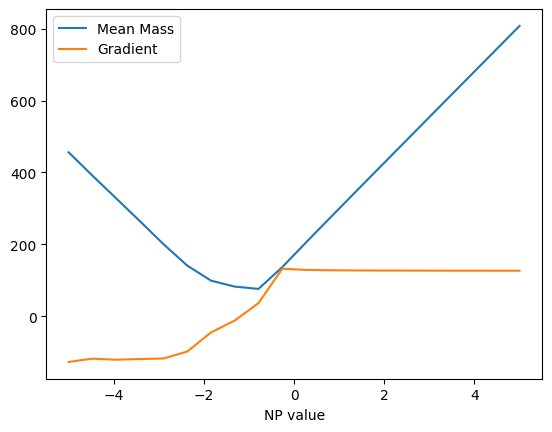

In [5]:
fig, ax = plt.subplots()
ax.plot(np_vals, mass_means, label='Mean Mass')
ax.plot(np_vals, grads, label='Gradient')
ax.set_xlabel("NP value")
ax.set_ylabel("")
ax.legend()

current position is -2.0 and the gradient is -77.54979
current position is -0.8747784 and the gradient is 0.25869423
current position is -0.8769495 and the gradient is -0.00016912818
current position is -0.87695086 and the gradient is -5.8487058e-05
current position is -0.87695086 and the gradient is -5.8487058e-05
final position is -0.87695086


Text(0, 0.5, 'Mean mass')

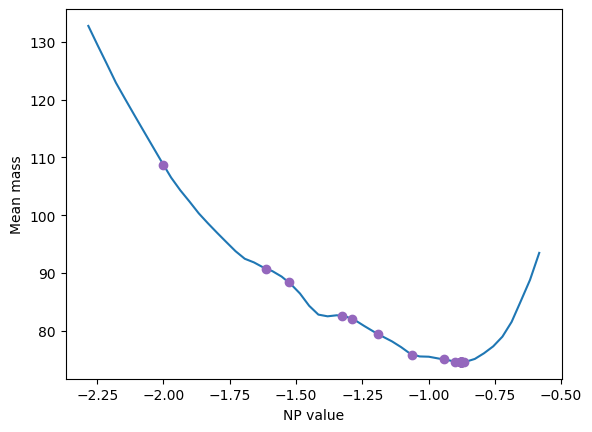

In [6]:
# Let's use gradient descent

steps = 50
a0 = -2. # initial position
alpha = 0.005 # step size

a0s, vals = [], []

for i in range(steps):
    val, grad = jax.value_and_grad(pipeline, argnums=1)(jets, a0)
    if i % 10 == 0:
        print("current position is", a0, "and the gradient is", grad)
    a0s.append(a0)
    vals.append(val)
    a0 = a0 - alpha * grad

print("final position is", a0)

opt_range = np.max(a0s) - np.min(a0s)
inter_steps = np.linspace(np.min(a0s) - opt_range/4, np.max(a0s) + opt_range/4, 50)
plt.plot(inter_steps, [pipeline(jets, x) for x in inter_steps])
plt.plot(a0s, vals, "o", c="C4", label="Steps taken by gradient descent")
plt.xlabel("NP value")
plt.ylabel("Mean mass")

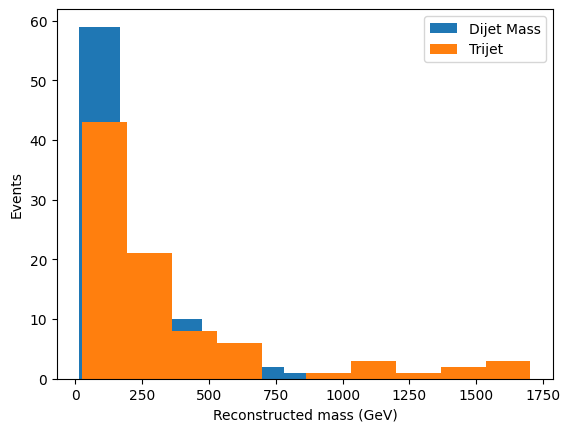

In [7]:
# let's use more sophisticated trijet mass calculation from calver-coffea-agc-demo

def get_trijet_mass(jets):
    """get trijet mass using combination with highest combined pt"""
    trijet = ak.combinations(jets, 3, fields=["j1", "j2", "j3"])
    trijet["p4"] = trijet.j1 + trijet.j2 + trijet.j3
    return trijet["p4"][ak.argmax(trijet.p4.pt, axis=1, keepdims=True)].mass


evtfilter = ak.num(arr["Jet_pt"]) >= 3. # need at least 3 jets now
jets = ak.zip(dict(zip(["pt","eta", "phi", "mass"], ak.unzip(arr))), with_name="Momentum4D")[evtfilter]

dijet_masses = get_mass(jets)
trijet_masses = get_trijet_mass(jets)

fig, ax = plt.subplots()
ax.hist(dijet_masses, label='Dijet Mass')
ax.hist(trijet_masses, label='Trijet')
ax.set_xlabel("Reconstructed mass (GeV)")
ax.set_ylabel("Events")
ax.legend()

In [8]:
# let's try to differentiate the new mass calculation

def trijet_pipeline(jets, a):
    """analysis pipeline: calculate mean of dijet masses"""
    return np.mean(get_trijet_mass(correct_jets(jets, a)))


jets = ak.to_backend(jets, "jax")

val_and_grad = jax.value_and_grad(trijet_pipeline, argnums=1)(jets, -1.)

# 'Cannot differentiate through argmax'

/Users/linogerlach/Projects/IRIS-HEP/venv/lib/python3.10/site-packages/awkward/_nplikes/array_module.py:63: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return self._module.asarray(obj, dtype=dtype)
/Users/linogerlach/Projects/IRIS-HEP/venv/lib/python3.10/site-packages/awkward/_nplikes/array_module.py:63: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return self._module.asarray(obj, dtype=dtype)


RuntimeError: Cannot differentiate through argmax

This error occurred while calling

    ak.argmax(
        <Array [[...], [...], ..., [...]] type='88 * var * float32'>
        axis = 1
        keepdims = True
    )

In [11]:
def get_trijet_mass_ad(jets, temperature=0.1):
    """
    differentiable approximation trijet mass
    replace argmax by softmax and return weighted sum
    temperature -- larger values make softmax closer to argmax (can get NaN, though)
    """
    trijet = ak.combinations(jets, 3, fields=["j1", "j2", "j3"])
    trijet["p4"] = trijet.j1 + trijet.j2 + trijet.j3
    weights = ak.softmax(temperature * trijet.p4.pt, axis=-1)
    return ak.sum(weights * trijet.p4.mass, axis=1)


def trijet_pipeline_ad(jets, a, temperature=0.1):
    """analysis pipeline: calculate mean of dijet masses"""
    return np.mean(get_trijet_mass_ad(correct_jets(jets, a), temperature))


val_and_grad = jax.value_and_grad(trijet_pipeline_ad, argnums=1)(jets, -1., 0.1)
print(val_and_grad)

(Array(136.43123, dtype=float32), Array(-105.89169, dtype=float32, weak_type=True))


trijet_mean = 352.35
trijet_ad_means = [317.33, 320.57, 329.67, 332.53, 335.11, 337.36, 339.29, 340.9, 347.83, nan]


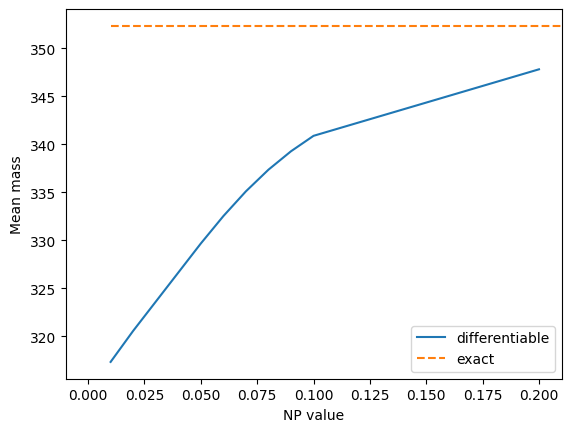

In [12]:
# investigate effects of temperature parameter

trijet_mean = np.mean(trijet_masses)

temperatures = [0.01, 0.02, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3]
trijet_ad_means = []

for t in temperatures:
    trijet_ad_masses = get_trijet_mass_ad(jets, t)
    trijet_ad_mean = np.mean(trijet_ad_masses)
    trijet_ad_means.append(trijet_ad_mean)

print(f'trijet_mean = {round(trijet_mean, 2)}')
print(f'trijet_ad_means = {[round(float(m), 2) for m in trijet_ad_means]}')

plt.plot(temperatures, trijet_ad_means, label='differentiable')
plt.plot(temperatures, [trijet_mean for _ in temperatures], label='exact', ls='--')
plt.xlabel("NP value")
plt.ylabel("Mean mass")
plt.gca().set_xlim([-0.01, 0.21])
plt.legend()

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

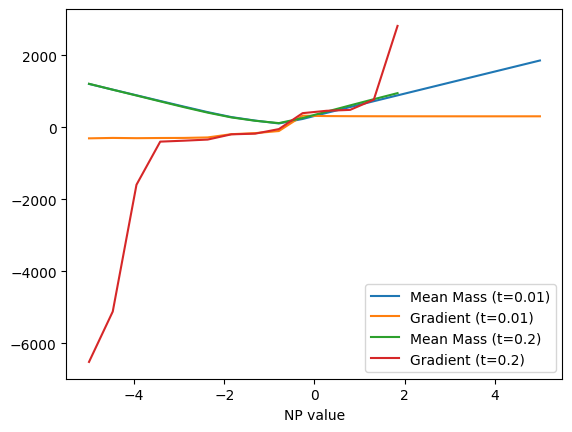

In [13]:
# What about the gradients?
# scan the analysis pipeline for various nuisance parameter values

fig, ax = plt.subplots()
np_vals = np.linspace(-5, 5, 20) 
for t in [0.01, 0.2]:
    vals_and_grads = []
    for a in tqdm(np_vals):
        vals_and_grads.append(jax.value_and_grad(trijet_pipeline_ad, argnums=1)(jets, a, temperature=t))
    vals_and_grads = np.array(vals_and_grads)
    
    # vals_and_grads = np.array([jax.value_and_grad(trijet_pipeline_ad, argnums=1)(jets, a, temperature=t) for a in np_vals])

    mass_means = vals_and_grads[:, 0]
    grads = vals_and_grads[:, 1]

    ax.plot(np_vals, mass_means, label=f'Mean Mass (t={t})')
    ax.plot(np_vals, grads, label=f'Gradient (t={t})')
    
ax.set_xlabel("NP value")
ax.set_ylabel("")
ax.legend()

In [ ]:
# Let's use gradient descent again

steps = 50
a0 = -2. # initial position
alpha = 0.001 # step size

a0s, vals = [], []

for i in range(steps):
    val, grad = jax.value_and_grad(trijet_pipeline_ad, argnums=1)(jets, a0, temperature=0.01)
    if i % 10 == 0:
        print("current position is", a0, "and the gradient is", grad)
    a0s.append(a0)
    vals.append(val)
    a0 = a0 - alpha * grad

print("final position is", a0)

opt_range = np.max(a0s) - np.min(a0s)
inter_steps = np.linspace(np.min(a0s) - opt_range/4, np.max(a0s) + opt_range/4, 50)
plt.plot(inter_steps, [trijet_pipeline_ad(jets, x, temperature=0.01) for x in inter_steps])
plt.plot(a0s, vals, "o", c="C4", label="Steps taken by gradient descent")
plt.xlabel("NP value")
plt.ylabel("Mean mass")

current position is -2.0 and the gradient is -260.27368
current position is -0.7009595 and the gradient is 1.1377711
current position is -0.7011823 and the gradient is 0.6033149
current position is -0.7012653 and the gradient is 0.4184183


Our input file is tiny. The following cell could be used instead to process 500 MB of data.

In [ ]:
import os

ttbar_file = "https://xrootd-local.unl.edu:1094//store/user/AGC/nanoAOD/"\
    "TT_TuneCUETP8M1_13TeV-powheg-pythia8/cmsopendata2015_ttbar_19981_PU25nsData2015v1_76X_"\
    "mcRun2_asymptotic_v12_ext4-v1_80000_0007.root"

# download for subsequent use
local_file_name = "ttbar.root"
if not os.path.exists(local_file_name):
    urllib.request.urlretrieve(ttbar_file, filename=local_file_name)